In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')

In [2]:
def ts_crossval(X, y, init_train_set, epsilon, C, kernel):
    
    """
    Inputs: 
    - Features array X
    - Target vector y
    - Percentage of dataset dedicated to initial train set (init_train_set)
    - Hyperparameters of SVR algorithm: C and epsilon
    - Kernel function to use (string)
    
    Output:
    - y_pred: the estimated target vector of the algorithm
    - y_test: the actual target vector that was aimed at predicting by y_pred
    """
    
    from sklearn.svm import SVR
    
    N = len(y)
    init_train_point = int(init_train_set * N)
    predictions=[]
    y_true = []
    for i in range(init_train_point, len(X)-1): #iterate over init_train_point and the last observation (-1)
        X_train = X[:i, :] #first the train set is composed of init_train_point observations, then init_train_point+1, ..., until N-1 observations.
        y_train = y[:i]
        model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train) #fit the SVR model with the train data
        X_test = X[i, :].reshape(1,-1) #the test set is always the observation that comes right after the last train observation
        y_test = y[i]
        y_pred = model.predict(X_test) 
        predictions.append(y_pred)
        y_true.append(y_test)
        
    y_true = np.array(y_true).reshape(-1,1)
    y_hat = np.array(predictions).reshape(-1,1)
    
    
    return y_hat, y_true


def epsilon_loss(y_true, y_pred, epsilon):
    
    """
    Function that computes the epsilon-insensitive mean squared loss for a given epsilon, a given vector of predictions 
    and a given vector of targets.
    """
    
    error = np.abs(y_true - y_pred) - epsilon
    squared_errors = [x**2 for x in error]
    return np.mean(squared_errors)

def plot_predictions(y_true, y_pred, epsilon):
    
    """
    Function that plots the predictions of the SVR algorithm vs. the actual targets, for a given epsilon.
    """
    
    plt.rcParams['figure.figsize']=(12,8)
    plt.style.use('ggplot')
    n = len(y_pred)
    x = np.arange(0,n, 1)
    plt.plot(x, y_pred)
    plt.plot(x, y_true)
    plt.plot(x, [epsilon]*n, '--', linewidth=3, color='black')
    plt.plot(x, [-epsilon]*n, '--', linewidth=3, color='black')
    plt.title('$Y_{test}$ vs $\hat{Y}_{test}$, for $\epsilon = $' + str(epsilon))
    plt.legend(['$\hat{Y}_{test}$', '$Y_{test}$', '$\pm$ epsilon'])
    plt.savefig('flateness_figure_for_epsilon=' + str(epsilon) + '.pdf')
    plt.show()
    
def plot_C_impact(y_true, y_preds, C_values, epsilon):
    """
    Function that plots 2 prediction vectors y_preds by the SVR algorithm depending on 2 different values of C 
    stored in C_values, against the actual true target vector y_true, for a given epsilon.
    """
    y_pred1, y_pred2 = y_preds
    C_0, C_1 = C_values
    
    n = len(y_pred1)
    x = np.arange(0,n,1)
    plt.plot(x, y_true)
    plt.plot(x, y_pred1)
    plt.plot(x, y_pred2)
    plt.plot(x, [y_true.mean() + epsilon]*n, '--', linewidth=3, color='black')
    plt.plot(x, [y_true.mean() - epsilon]*n, '--', linewidth=3, color='black')
    plt.title('Y vs $\hat{Y}$, for constant $\epsilon$  and variant C')
    plt.legend(['Y', '$\hat{Y}$ with C = ' + str(C_0), '$\hat{Y}$ with C = ' + str(C_1), '$\pm$ $\epsilon$'])
    plt.savefig('C_impact.pdf')
    

def RMSE(y_hat, y_true):
    from sklearn.metrics import mean_squared_error
    rmse = mean_squared_error(y_hat, y_true, squared=False)
    return rmse

def max_error(y_hat, y_true):
    from sklearn.metrics import mean_absolute_error
    mae = mean_absolute_error(y_hat, y_true)
    max_err = np.max(mae)
    return max_err

In [3]:
data = pd.read_csv('financial_data.csv')
data.insert(loc=1, column='y_t+1', value=data['y_t'].shift(-1))
treasury_bonds = ['Switzerland', 'Japan', 'Germany', 'France', 'US']
for bonds in treasury_bonds:
    data[bonds + '10Y'] = data[bonds + '10Y'].pct_change()
data.dropna(inplace=True)
data.head()

,Date,y_t+1,y_t,Switzerland10Y,Japan10Y,Germany10Y,France10Y,US10Y,CAC40,DAX,...,SP500,VIX,GOLD,OIL,SILVER,EURCHF,EURGBP,EURUSD,GBPUSD,USDJPY
1,2015-01-08,0.001280,0.006036,-0.135747,0.038194,0.041943,0.048387,0.003557,0.007133,0.005111,...,0.000127,0.000127,-0.007161,0.014910,-0.005617,-0.000358,0.002604,-0.005346,-0.007918,-0.006317
2,2015-01-09,-0.008880,0.001280,0.052356,-0.033445,0.084746,0.024359,0.014684,0.035227,0.033009,...,0.016550,0.016550,-0.001819,0.002874,-0.009677,0.000000,-0.001454,-0.003320,-0.002011,0.005177
3,2015-01-13,0.000123,-0.008880,0.174129,-0.024221,-0.058594,-0.022528,-0.003493,-0.019225,-0.019410,...,0.001783,0.001783,0.006270,-0.008852,0.002138,0.000025,-0.002134,-0.003379,-0.001299,0.004208
4,2015-01-14,-0.005860,0.000123,-0.131356,-0.053191,-0.010373,-0.051216,-0.060591,0.026263,0.029865,...,-0.006418,-0.006418,0.001297,-0.003915,0.035060,-0.000175,-0.002139,-0.003306,-0.001260,0.000981
5,2015-01-15,0.006615,-0.005860,-0.185366,-0.041199,-0.094340,-0.113360,-0.005330,-0.015749,-0.012544,...,-0.017221,-0.017221,0.000081,0.054904,-0.009918,0.000000,-0.004498,-0.004509,0.000000,-0.004515


In [4]:
#data.index = data['Date']
#data.index = pd.to_datetime(data.index)
#data.drop(columns='Date', inplace=True)

# 1. Data preprocessing

In [4]:
data.max()

Date              2019-12-23
y_t+1              0.0138157
y_t                0.0138157
Switzerland10Y            34
Japan10Y                 inf
Germany10Y               inf
France10Y                 10
US10Y              0.0882528
CAC40              0.0406037
DAX                0.0485205
DOWJONES           0.0387549
EURO100            0.0401054
NIKKEI225          0.0742617
SP500              0.0742617
VIX                0.0742617
GOLD               0.0455681
OIL                 0.116213
SILVER             0.0517467
EURCHF             0.0334561
EURGBP             0.0535272
EURUSD             0.0281453
GBPUSD             0.0284796
USDJPY             0.0215369
dtype: object

In [5]:
data.drop(columns=['Switzerland10Y', 'Japan10Y', 'Germany10Y', 'France10Y', 'US10Y'], inplace=True)

In [6]:
data.isnull().sum()

Date         0
y_t+1        0
y_t          0
CAC40        0
DAX          0
DOWJONES     0
EURO100      0
NIKKEI225    0
SP500        0
VIX          0
GOLD         0
OIL          0
SILVER       0
EURCHF       0
EURGBP       0
EURUSD       0
GBPUSD       0
USDJPY       0
dtype: int64

In [7]:
data.head()

,Date,y_t+1,y_t,CAC40,DAX,DOWJONES,EURO100,NIKKEI225,SP500,VIX,GOLD,OIL,SILVER,EURCHF,EURGBP,EURUSD,GBPUSD,USDJPY
1,2015-01-08,0.001280,0.006036,0.007133,0.005111,0.012180,0.006768,0.000127,0.000127,0.000127,-0.007161,0.014910,-0.005617,-0.000358,0.002604,-0.005346,-0.007918,-0.006317
2,2015-01-09,-0.008880,0.001280,0.035227,0.033009,0.018221,0.032502,0.016550,0.016550,0.016550,-0.001819,0.002874,-0.009677,0.000000,-0.001454,-0.003320,-0.002011,0.005177
3,2015-01-13,0.000123,-0.008880,-0.019225,-0.019410,-0.009567,-0.016052,0.001783,0.001783,0.001783,0.006270,-0.008852,0.002138,0.000025,-0.002134,-0.003379,-0.001299,0.004208
4,2015-01-14,-0.005860,0.000123,0.026263,0.029865,-0.006998,0.025048,-0.006418,-0.006418,-0.006418,0.001297,-0.003915,0.035060,-0.000175,-0.002139,-0.003306,-0.001260,0.000981
5,2015-01-15,0.006615,-0.005860,-0.015749,-0.012544,-0.010650,-0.013758,-0.017221,-0.017221,-0.017221,0.000081,0.054904,-0.009918,0.000000,-0.004498,-0.004509,0.000000,-0.004515


# 2. SVR

In [8]:
from sklearn.svm import SVR

In [9]:
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

### 2.1. Hyperparameters analysis

Time consumption

In [10]:
C = 1
kernel = 'rbf'
train_set = 0.7
N = len(y)
k = int(train_set * N)
X_train = X[:k, :]
y_train = y[:k]

In [11]:
epsilons = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
n_SVs = []
for epsilon in epsilons:
    model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
    n_SV = model.support_
    n_SV = n_SV.shape[0]
    n_SVs.extend((epsilon, n_SV))
n_SVs = np.array(n_SVs).reshape(-1, 2)
table = pd.DataFrame(n_SVs, columns=['epsilon', 'Number of SVs']) 
    

In [12]:
table

,epsilon,Number of SVs
0,1.000000e-07,771.0
1,1.000000e-06,767.0
2,1.000000e-05,768.0
3,1.000000e-04,758.0
4,1.000000e-03,647.0
5,1.000000e-02,11.0
6,1.000000e-01,0.0
7,1.000000e+00,0.0


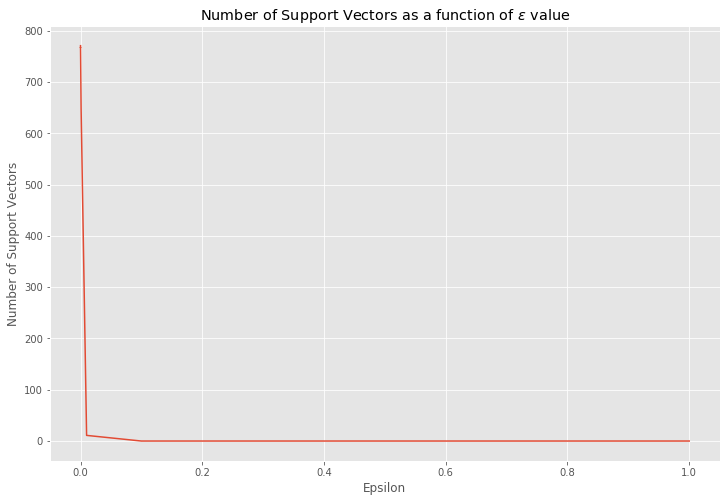

In [13]:
plt.plot(table['epsilon'].values, table['Number of SVs'].values)
plt.xlabel('Epsilon')
plt.ylabel('Number of Support Vectors')
plt.title('Number of Support Vectors as a function of $\epsilon$ value')
plt.savefig('nSVsepsilon.pdf')

,epsilon,Train CPU time (s)
0,1.000000e-07,0.275135
1,1.000000e-06,0.256343
2,1.000000e-05,0.297928
3,1.000000e-04,0.263424
4,1.000000e-03,0.157719
5,1.000000e-02,0.000922
6,1.000000e-01,0.000496
7,1.000000e+00,0.000457


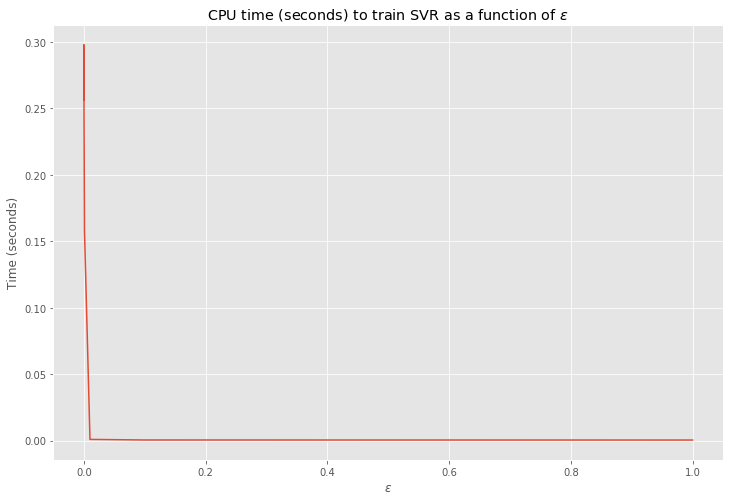

In [14]:
exec_time = []
import time
for epsilon in [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
    start_time = time.time()
    model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
    ex_time = time.time() - start_time
    exec_time.extend((epsilon, ex_time))
exec_time = np.array(exec_time).reshape((-1, 2))
table = pd.DataFrame(exec_time, columns=['epsilon', 'Train CPU time (s)'])
plt.plot(table['epsilon'].values, table['Train CPU time (s)'].values)
plt.xlabel('$\epsilon$')
plt.ylabel('Time (seconds)')
plt.title('CPU time (seconds) to train SVR as a function of $\epsilon$')
plt.savefig('epsilon_cpu.pdf')
table

CPU Train time for C

,C,Train CPU time (s)
0,1.000000e-07,0.002286
1,1.000000e-06,0.001574
2,1.000000e-05,0.001378
3,1.000000e-04,0.001335
4,1.000000e-03,0.001509
5,1.000000e-02,0.000891
6,1.000000e-01,0.000850
7,1.000000e+00,0.001185


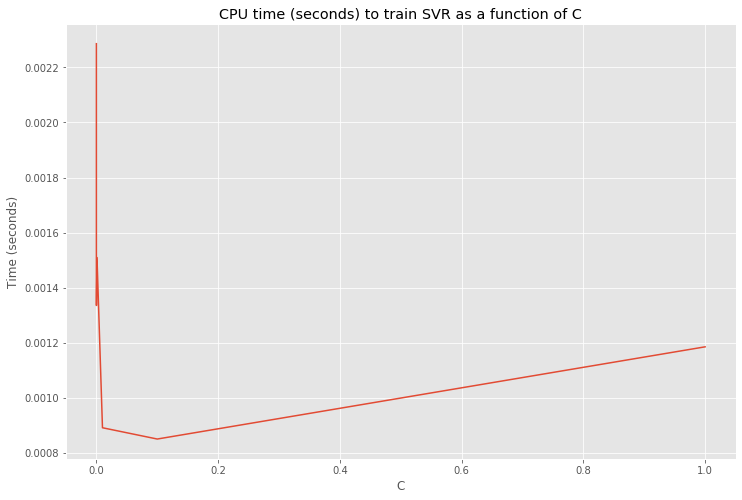

In [15]:
epsilon = 0.01
exec_time = []
import time
for C in [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]:
    start_time = time.time()
    model = SVR(epsilon=epsilon, C=C, kernel=kernel).fit(X_train, y_train)
    ex_time = time.time() - start_time
    exec_time.extend((C, ex_time))
exec_time = np.array(exec_time).reshape((-1, 2))
table = pd.DataFrame(exec_time, columns=['C', 'Train CPU time (s)'])
plt.plot(table['C'].values, table['Train CPU time (s)'].values)
plt.xlabel('C')
plt.ylabel('Time (seconds)')
plt.title('CPU time (seconds) to train SVR as a function of C')
plt.savefig('C_CPU.pdf')
table

Relationship between hyperparameters and test error

In [16]:
epsilon = 0.003
kernel = 'rbf'

1.1749678597348045e-05
1.1915881002699755e-05
1.2035342500912726e-05
1.2106517049221693e-05
1.2312016159091614e-05
1.226058447362274e-05
1.2541459400495202e-05
1.2629048264427418e-05
1.2604800569671899e-05
1.2671410420017194e-05
1.2839551043368118e-05
1.2834230039404574e-05
1.296741626487785e-05
1.2982307127010907e-05
1.3212203595737791e-05
1.3136154581202166e-05
1.3337324992636907e-05
1.3425415651646256e-05
1.3317054598016446e-05
1.336947811508469e-05
1.3511913960423199e-05
1.3654879077480942e-05
1.367438692308618e-05
1.3700951151435746e-05
1.3664494803873215e-05
1.374199824573902e-05
1.3831255990095383e-05
1.3964243630699115e-05
1.3970378709247125e-05
1.3979611916620245e-05
1.4039971885670808e-05
1.4183946371696054e-05
1.4221264474360953e-05
1.4166057167417941e-05
1.422973255588478e-05
1.444072381962339e-05
1.4399622695606262e-05
1.4449124087539863e-05
1.4552406645623738e-05
1.4632687980320289e-05
1.468017898988255e-05
1.4717679620282375e-05
1.4844025769388397e-05
1.4861750319466935e

,C,test errors
0,0.100000,0.000012
1,0.118367,0.000012
2,0.136735,0.000012
3,0.155102,0.000012
4,0.173469,0.000012
5,0.191837,0.000012
6,0.210204,0.000013
7,0.228571,0.000013
8,0.246939,0.000013
9,0.265306,0.000013


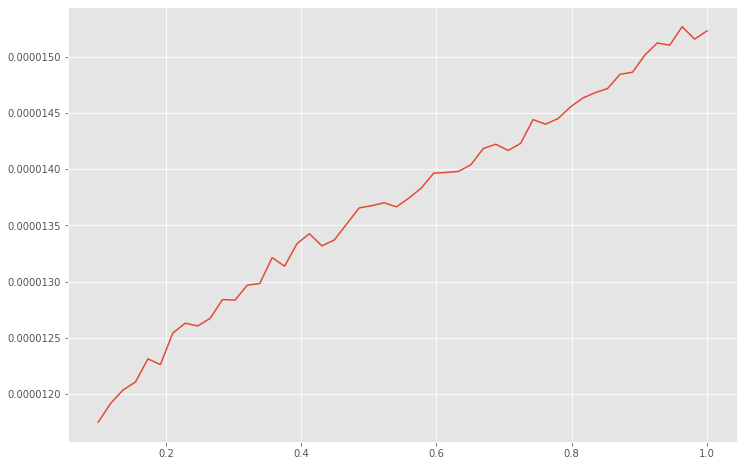

In [17]:
%%time
from sklearn.metrics import mean_squared_error
MSE = mean_squared_error
init_train_set = 0.75
results=[]
for C in list(np.linspace(0.1, 1)):
    y_hat, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=C, kernel=kernel)
    test_error = MSE(y_true, y_hat)
    print(test_error)
    results.extend((C, test_error))
    
results = np.array(results).reshape((-1, 2))
results = pd.DataFrame(results, columns=['C', 'test errors'])
plt.plot(results['C'].values, results['test errors'].values)
results    
    

Text(0.5, 1.0, 'mse_C.pdf')

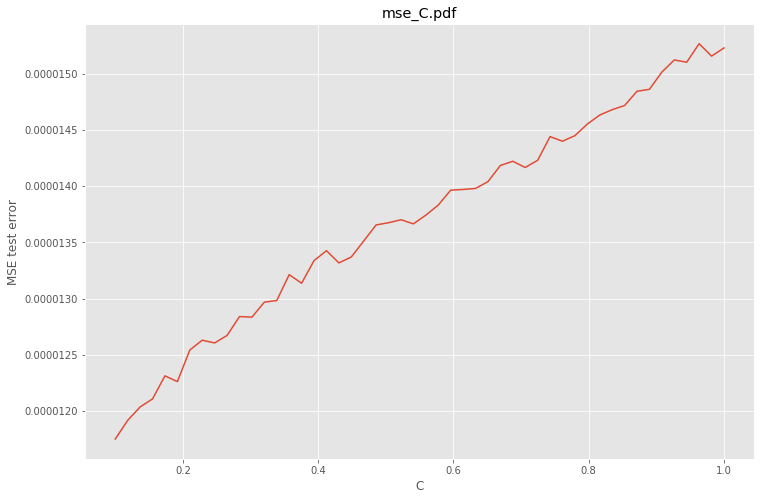

In [18]:
plt.plot(results['C'].values, results['test errors'].values)
plt.xlabel('C')
plt.ylabel('MSE test error')
plt.title('mse_C.pdf')

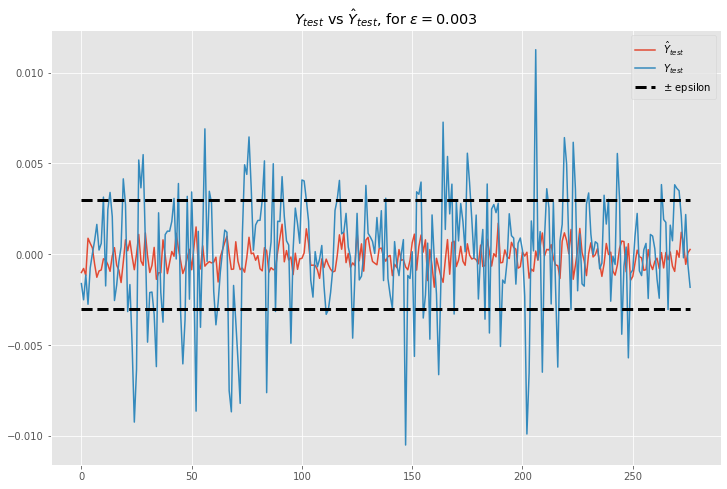

4.431319658852335e-06

In [19]:
epsilon = 0.003
y_hat, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=y.std(), kernel=kernel)
plot_predictions(y_true, y_hat, epsilon)
epsilon_loss(y_hat, y_true, epsilon)


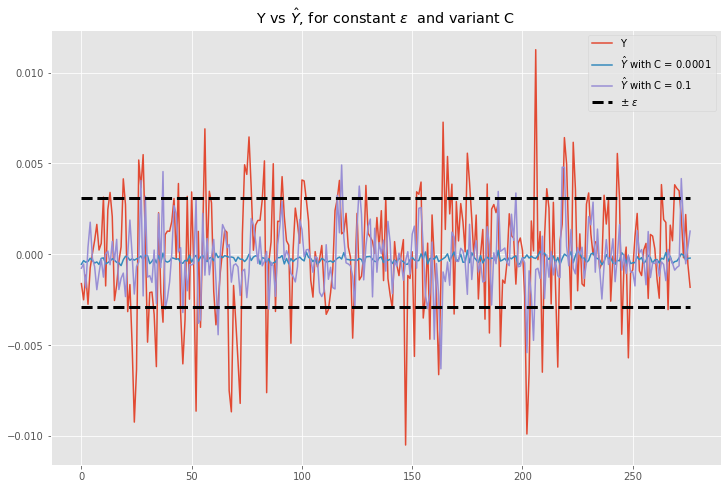

In [20]:
C_0 = 0.0001
C_1 = 0.1
epsilon = 0.003
y_hat1, y_true1 = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=C_0, kernel=kernel)
y_hat2, y_true2 = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=C_1, kernel=kernel)

plot_C_impact(y_true, y_preds=[y_hat1, y_hat2], C_values=[C_0, C_1], epsilon=epsilon)

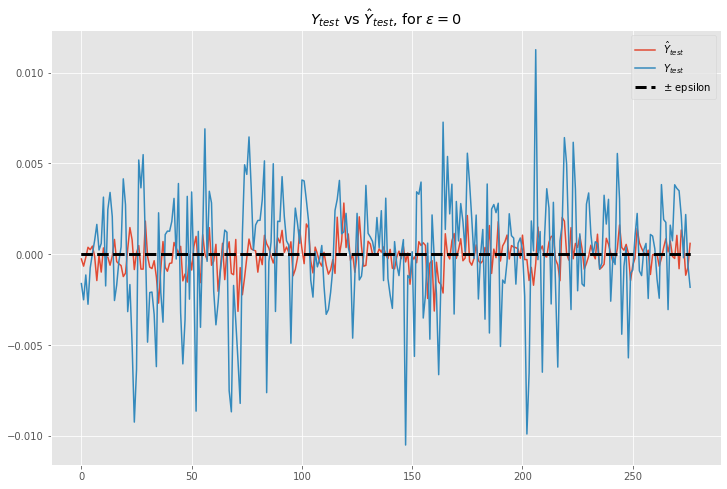

CPU times: user 12.2 s, sys: 168 ms, total: 12.3 s
Wall time: 13.6 s


1.0620192221735138e-05

In [21]:
%%time
epsilon = 0
y_hat, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=y.std(), kernel=kernel)
plot_predictions(y_true, y_hat, epsilon)
epsilon_loss(y_hat, y_true, epsilon)

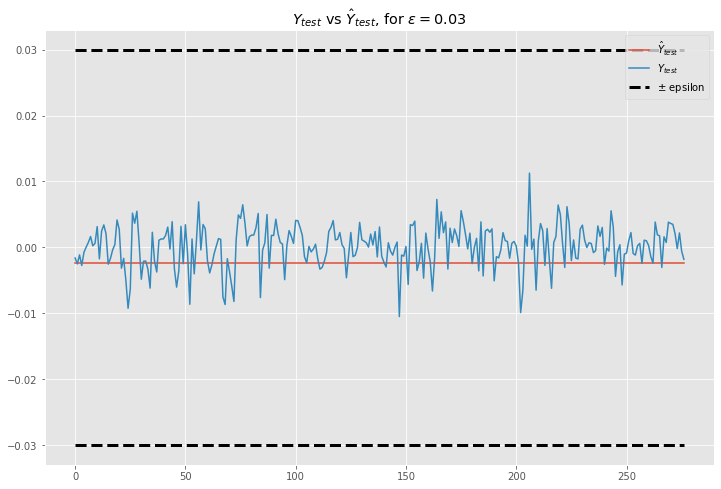

0.0007110534271586859

In [22]:
epsilon=0.03
y_hat, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=y.std(), kernel=kernel)
plot_predictions(y_true, y_hat, epsilon)
epsilon_loss(y_hat, y_true, epsilon)

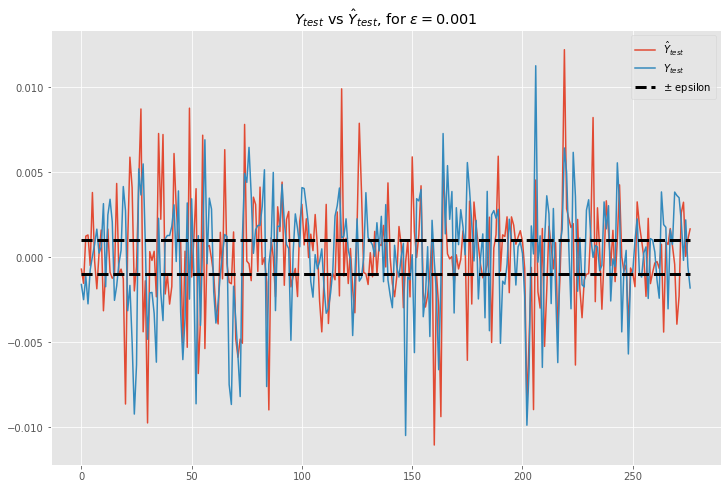

In [23]:
epsilon = 0.001
y_hat, y_true = ts_crossval(X, y, init_train_set, epsilon=epsilon, C=1, kernel=kernel)
plot_predictions(y_true, y_hat, epsilon)

## Computational time as a function of N and D

In [24]:
n_observations = len(y)
n_observations

1111

,Number of observations,Train CPU time (s)
0,10.0,0.001329
1,1111.0,0.001598


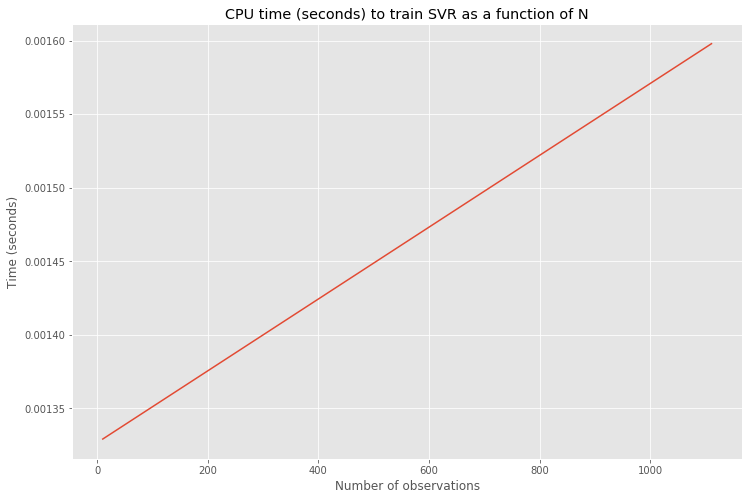

In [25]:
import time
exec_time = []
for n in [10, n_observations]:
    X_ = X[:n,:]
    y_ = y[:n]
    start_time = time.time()
    SVR().fit(X_, y_)
    ex_time = time.time() - start_time
    exec_time.extend((n, ex_time))
exec_time = np.array(exec_time).reshape((-1, 2))
table = pd.DataFrame(exec_time, columns=['Number of observations', 'Train CPU time (s)'])
plt.plot(table['Number of observations'].values, table['Train CPU time (s)'].values)
plt.xlabel('Number of observations')
plt.ylabel('Time (seconds)')
plt.title('CPU time (seconds) to train SVR as a function of N')
plt.savefig('n_CPU.pdf')
table

In [26]:
D = X.shape[1]
D

16

,Number of features,Train CPU time (s)
0,1.0,0.000904
1,2.0,0.001357
2,3.0,0.001117
3,4.0,0.001280
4,5.0,0.000951
5,6.0,0.001010
6,7.0,0.001164
7,8.0,0.000902
8,9.0,0.000770
9,10.0,0.000741


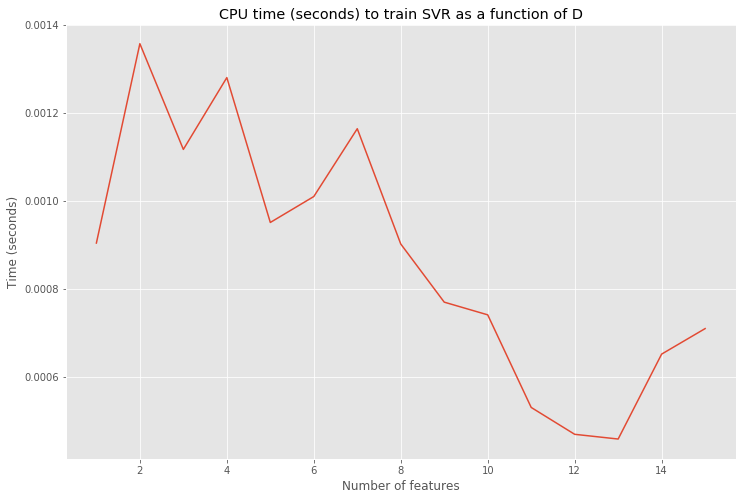

In [27]:
import time
exec_time = []
for d in range(1,D):
    X_ = X[:,:d]
    start_time = time.time()
    SVR().fit(X_, y)
    ex_time = time.time() - start_time
    exec_time.extend((d, ex_time))
exec_time = np.array(exec_time).reshape((-1, 2))
table = pd.DataFrame(exec_time, columns=['Number of features', 'Train CPU time (s)'])
plt.plot(table['Number of features'].values, table['Train CPU time (s)'].values)
plt.xlabel('Number of features')
plt.ylabel('Time (seconds)')
plt.title('CPU time (seconds) to train SVR as a function of D')
plt.savefig('D_CPU.pdf')
table

## Sensitivity of the algorithm with respect to number of observations

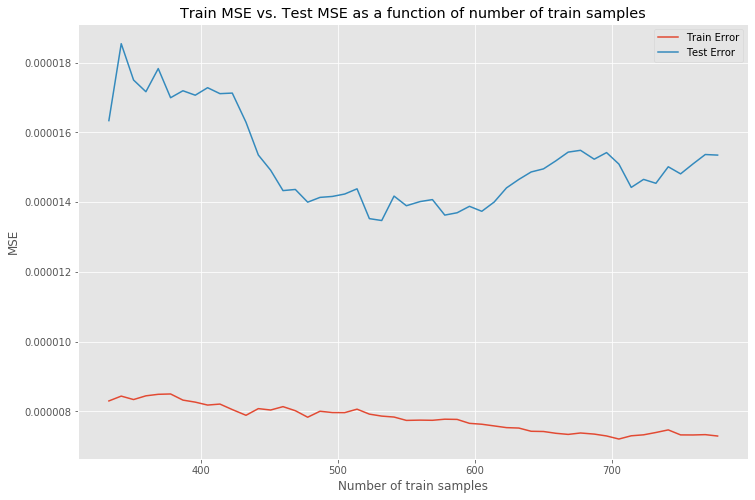

In [28]:
train_sets = list(np.linspace(0.3, 0.7))
epsilon = y.std()
errors=[]
train_obs = []
from sklearn.metrics import mean_squared_error
for train_set in train_sets:
    k = int(train_set*n_observations)
    train_obs.append(k)
    X_train = X[:k,:]
    y_train = y[:k]
    model = SVR(epsilon=epsilon).fit(X_train, y_train)
    X_test = X[k+1:,:]
    y_test = y[k+1:]
    y_hat = model.predict(X_test)
    test_error = mean_squared_error(y_test, y_hat)
    train_error = mean_squared_error(model.predict(X_train), y_train)
    errors.extend((train_error, test_error))
errors = np.array(errors).reshape((-1, 2))
plt.plot(np.array(train_obs).reshape(-1,1), errors[:,0])
plt.plot(np.array(train_obs).reshape(-1,1), errors[:,1])
plt.xlabel('Number of train samples')
plt.ylabel('MSE')
plt.legend(['Train Error', 'Test Error'])
plt.title('Train MSE vs. Test MSE as a function of number of train samples')
plt.savefig('MSE_train_test.pdf')
#errors = pd.DataFrame(errors, columns=['Train Error', 'Test Error'])

In [29]:
train_sets = list(np.linspace(0.3, 0.7))
epsilon = y.std()
errors=[]
train_obs = []
from sklearn.metrics import mean_squared_error
for train_set in train_sets:
    k = int(train_set*n_observations)
    train_obs.append(k)
    X_train = X[:k,:]
    y_train = y[:k]
    model = SVR(epsilon=epsilon).fit(X_train, y_train)
    X_test = X[k+1:,:]
    y_test = y[k+1:]
    y_hat = model.predict(X_test)
    error = mean_squared_error(y_test, y_hat) / y_test.var()
    errors.append(error)
    print(error)

1.6923333284494066
1.9878659334261528
1.9303290526769654
1.8918016094686367
1.994901289424313
1.901080924871899
1.915452144944867
1.931946836089781
1.937860953480381
1.902982574995003
1.893700422077277
1.8198289773171983
1.7283212650739663
1.6813422055332747
1.6049198331020793
1.5961541127682668
1.5590934694902296
1.5734761746200718
1.5682948026063477
1.5854305371094173
1.606370464278459
1.5053656300607776
1.4922904181804366
1.5712047097824826
1.5308397303080865
1.5240457249744732
1.520230720264402
1.457055872779231
1.4586027892555802
1.4609197953336432
1.427849750368586
1.4535739054936445
1.4737426120967902
1.4933906184239032
1.495210497312895
1.4845056708541386
1.491157792733744
1.4957531710713718
1.4833269249079066
1.462812301716963
1.4574943115234644
1.4613280956126826
1.4231364874573649
1.4430253547195417
1.4257504193573283
1.5193688232589138
1.5246853014647777
1.5474558272375165
1.5621109260727546
1.5385096191442764


,Number of observations,nMSE test error
0,333.0,1.692333
1,342.0,1.987866
2,351.0,1.930329
3,360.0,1.891802
4,369.0,1.994901
5,378.0,1.901081
6,387.0,1.915452
7,396.0,1.931947
8,405.0,1.937861
9,414.0,1.902983


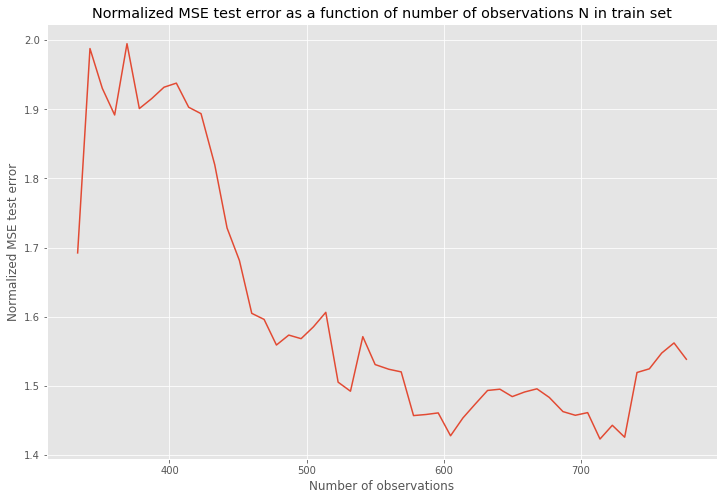

In [30]:
n_obs = np.array(train_obs).reshape(-1,1)
table = np.concatenate((n_obs, np.array(errors).reshape(-1,1)), axis=1)
table = pd.DataFrame(table, columns=['Number of observations', 'nMSE test error'])
plt.plot(table['Number of observations'].values, table['nMSE test error'].values)
plt.xlabel('Number of observations')
plt.ylabel('Normalized MSE test error')
plt.title('Normalized MSE test error as a function of number of observations N in train set')
plt.savefig('norm_MSE.pdf')
table

## Model selection

In [31]:
def find_optimal_hyperparameters(X,y,train_set, epsilon_start,
                                C_start, kernel):
    
    from sklearn.metrics import mean_squared_error
    MSE = mean_squared_error
    VAR_y = (y.std())**2
    
    epsilons = list(np.linspace(epsilon_start/3, epsilon_start, num=10))
    Cs = list(np.linspace(C_start/3, C_start, num=10))
    
    errors = []
    for epsilon in epsilons:
        y_hat, y_true = ts_crossval(X, y, init_train_set=train_set, epsilon=epsilon, 
                                    C=C_start, kernel=kernel)
        norm_mse = MSE(y_true, y_hat) / VAR_y
        errors.extend((epsilon, norm_mse))
        print('Epsilon: ' + str(epsilon), 'Normalize MSE: ' + str(norm_mse))
    errors = np.array(errors).reshape((-1, 2))
    idx = np.argmin(errors[:,1])
    best_epsilon = errors[idx,:][0]
    
    errors = []
    for C in Cs:
        y_hat, y_true = ts_crossval(X, y, init_train_set=train_set, epsilon=best_epsilon, 
                                    C=C, kernel=kernel)
        
        norm_mse = MSE(y_true, y_hat) / VAR_y
        errors.extend((C, norm_mse))
        print('C: ' + str(C), 'Normalize MSE: ' + str(norm_mse))
        
        
    errors = np.array(errors).reshape((-1, 2))
    idx = np.argmin(errors[:,1])
    best_C = errors[idx,:][0]
    
    y_hat, y_true = ts_crossval(X, y, init_train_set=train_set, epsilon=best_epsilon,
                               C = best_C, kernel=kernel)
    norm_mse = MSE(y_true, y_hat) / VAR_y
    
    return best_epsilon, best_C, norm_mse

In [32]:
%%time
epsilon_0 = y.std()
C_0 = y.std()
train_set = 0.7
best_epsilon, best_C, min_error = find_optimal_hyperparameters(X,y,train_set=train_set, epsilon_start=epsilon_0,
                                                              C_start=C_0, kernel='rbf')
optimals = np.array( [np.nan]*100 ).reshape(-1,1)
optimals[0] = min_error
for i in range(1, len(optimals)):
    best_epsilon, best_C, min_error = find_optimal_hyperparameters(X,y,train_set,best_epsilon,best_C,'rbf')
    optimals[i] = min_error
    if optimals[i] >= optimals[i-1]:
        break

Epsilon: 0.0011386932976963544 Normalize MSE: 0.8428131504342661
Epsilon: 0.0013917362527399886 Normalize MSE: 0.8379413976968869
Epsilon: 0.001644779207783623 Normalize MSE: 0.8452819666419212
Epsilon: 0.0018978221628272573 Normalize MSE: 0.8442176637687826
Epsilon: 0.0021508651178708915 Normalize MSE: 0.8508650828239428
Epsilon: 0.0024039080729145257 Normalize MSE: 0.857099395266059
Epsilon: 0.0026569510279581604 Normalize MSE: 0.85847232800085
Epsilon: 0.002909993983001794 Normalize MSE: 0.860252416671545
Epsilon: 0.003163036938045429 Normalize MSE: 0.8666122069387461
Epsilon: 0.003416079893089063 Normalize MSE: 0.8672054800259741
C: 0.0011386932976963544 Normalize MSE: 0.8289514359887474
C: 0.0013917362527399886 Normalize MSE: 0.8355470920950401
C: 0.001644779207783623 Normalize MSE: 0.8341468613625547
C: 0.0018978221628272573 Normalize MSE: 0.8347219600881371
C: 0.0021508651178708915 Normalize MSE: 0.8412315478066622
C: 0.0024039080729145257 Normalize MSE: 0.8340799958487146
C: 0.

In [33]:
print('Minimal nMSE:' + str(optimals[i]), 'Optimal epsilon: ' + str(best_epsilon), 'Optimal C: ' + str(best_C))

Minimal nMSE:[0.82264382] Optimal epsilon: 0.0011855531041859162 Optimal C: 0.0004295482261543176


In [34]:
y_pred, y_true = ts_crossval(X, y, 0.7, best_epsilon, best_C, 'rbf')

Text(0, 0.5, 'Daily Return')

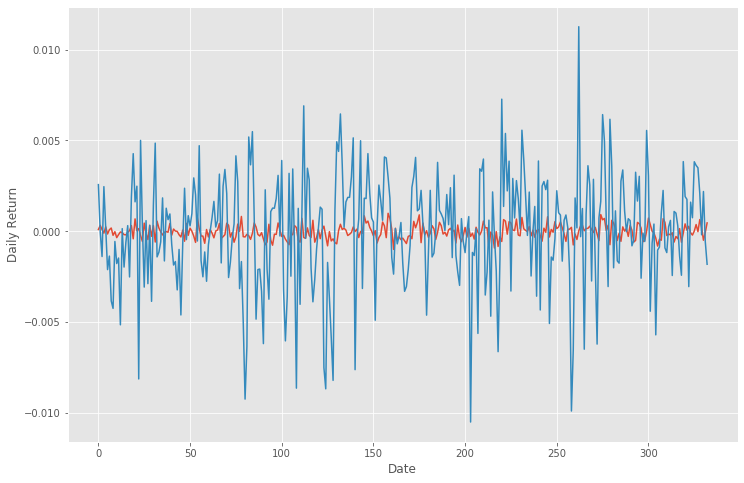

In [35]:
plt.rcParams['figure.figsize']=(12,8)
plt.style.use('ggplot')
n = len(y_pred)
x = np.arange(0,n, 1)
plt.plot(x, y_pred)
plt.plot(x, y_true)
plt.xlabel('Date')
plt.ylabel('Daily Return')


# SVR vs. LWPR predictions comparison

In [36]:
LWPR = pd.read_csv('predictions_LWPR_opti.csv')

In [37]:
LWPR.drop(axis=0, index=333, inplace=True)
LWPR['SVR predictions'] = pd.DataFrame(data=y_pred).shift(-1).values
LWPR.rename(columns={"Y": "True portfolio daily returns", "yPrediction": "LWPR predictions"}, inplace=True)
LWPR.index=LWPR.Date

Text(0, 0.5, 'Daily returns')

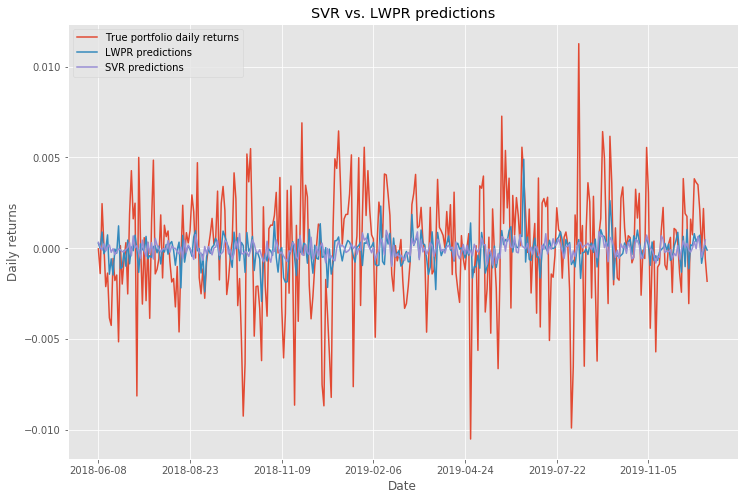

In [38]:
LWPR.plot()
plt.title('SVR vs. LWPR predictions')
plt.xlabel('Date')
plt.ylabel('Daily returns')